# Capstone Project: MovieLens Data EDA and Baseline Model

This notebook demonstrates exploratory data analysis (EDA) and baseline modeling using the MovieLens dataset. We will load and merge the movies and ratings data, create movie-level aggregated features, and build a baseline Logistic Regression model to predict whether a movie is popular (defined as having an average rating ≥ 4).


In [62]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style='whitegrid')
%matplotlib inline

from google.colab import drive  # Only needed in Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

Load the MovieLens dataset. Ensure that `movies.csv` and `ratings.csv` are in the same directory as this notebook.


In [64]:
# Define file paths on Google Drive
movies_path = '/content/drive/MyDrive/movies.csv'
ratings_path = '/content/drive/MyDrive/ratings.csv'

# ---------------------------
# Load the movies data
# ---------------------------
# Since the sample shows a pipe-separated file with no header, we specify:
movies = pd.read_csv(
    movies_path,
    encoding='latin-1',
    sep='|',
    header=None,
    # Define column names based on the original MovieLens 100K movies file (u.item)
    names=["movieId", "title", "release_date", "video_release_date", "IMDb_URL", "unknown",
           "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary",
           "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
           "Thriller", "War", "Western"],
    usecols=[0, 1],  # Only load movieId and title
    on_bad_lines='skip'
)

print("Movies DataFrame read using pipe separator with no header and usecols=[0,1]:")
display(movies.head())

# ---------------------------
# Load the ratings data
# ---------------------------
# For ratings, we assume the file is tab-separated.
ratings = pd.read_csv(
    ratings_path,
    encoding='latin-1',
    sep='\t',
    names=['userId', 'movieId', 'rating', 'timestamp'],
    on_bad_lines='skip'
)

# ---------------------------
# Diagnostics: Inspect the Raw Data
# ---------------------------
print("Movies DataFrame shape:", movies.shape)      # Expected: ~1682 rows for MovieLens 100K (or similar)
print("Ratings DataFrame shape:", ratings.shape)      # Expected: ~100000 rows for MovieLens 100K

# Check data types of the key columns
print("\nRatings 'movieId' type:", ratings['movieId'].dtype)
print("Movies 'movieId' type:", movies['movieId'].dtype)

# Display the first few rows of each DataFrame
print("\nMovies DataFrame Head:")
display(movies.head())

print("\nRatings DataFrame Head:")
display(ratings.head())

# Check unique values in the movies 'movieId' column
print("\nUnique movieIds in movies DataFrame:")
print(movies['movieId'].unique()[:10])  # Display first 10 unique movieIds

# Check how many ratings each movie received in the raw ratings DataFrame
ratings_per_movie = ratings.groupby('movieId').size()
print("\nRatings per movie (raw):")
print(ratings_per_movie.describe())


Movies DataFrame read using pipe separator with no header and usecols=[0,1]:


,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Movies DataFrame shape: (1682, 2)
Ratings DataFrame shape: (100000, 4)

Ratings 'movieId' type: int64
Movies 'movieId' type: int64

Movies DataFrame Head:


,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)



Ratings DataFrame Head:


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596



Unique movieIds in movies DataFrame:
[ 1  2  3  4  5  6  7  8  9 10]

Ratings per movie (raw):
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64


## Data Merging and Cleaning

Merge the movies and ratings datasets on the common column (`movieId`) and perform basic cleaning.


In [65]:
# Merge the ratings and movies DataFrames on 'movieId'
df = pd.merge(ratings, movies, on='movieId')

# Check the shape of the merged DataFrame (should be close to 100,000 rows)
print("\nMerged DataFrame shape (should be close to 100000 rows):", df.shape)

# Display the first 10 rows of the merged DataFrame to ensure multiple ratings per movie are present
print("\nMerged DataFrame Head:")
display(df.head(10))

# Verify the number of ratings per movie in the merged DataFrame
ratings_per_movie_merged = df.groupby('movieId').size()
print("\nRatings per movie (merged):")
print(ratings_per_movie_merged.describe())




Merged DataFrame shape (should be close to 100000 rows): (100000, 5)

Merged DataFrame Head:


,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
5,298,474,4,884182806,Dr. Strangelove or: How I Learned to Stop Worr...
6,115,265,2,881171488,"Hunt for Red October, The (1990)"
7,253,465,5,891628467,"Jungle Book, The (1994)"
8,305,451,3,886324817,Grease (1978)
9,6,86,3,883603013,"Remains of the Day, The (1993)"



Ratings per movie (merged):
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64


## Exploratory Data Analysis (EDA)

Let's explore the distribution of user ratings and the count of ratings per movie.


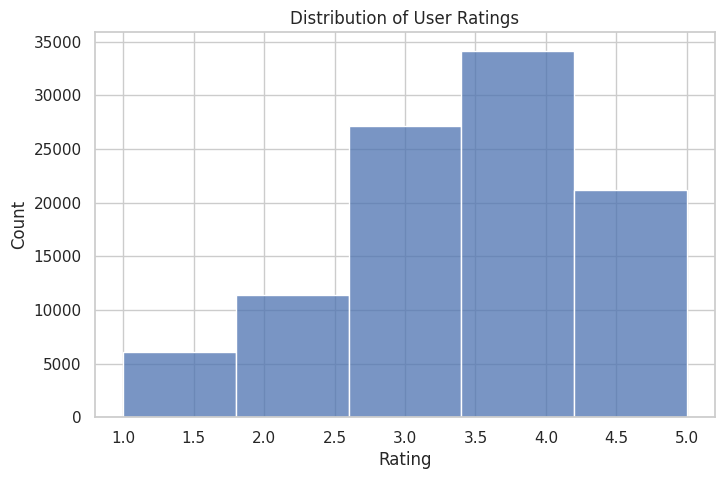

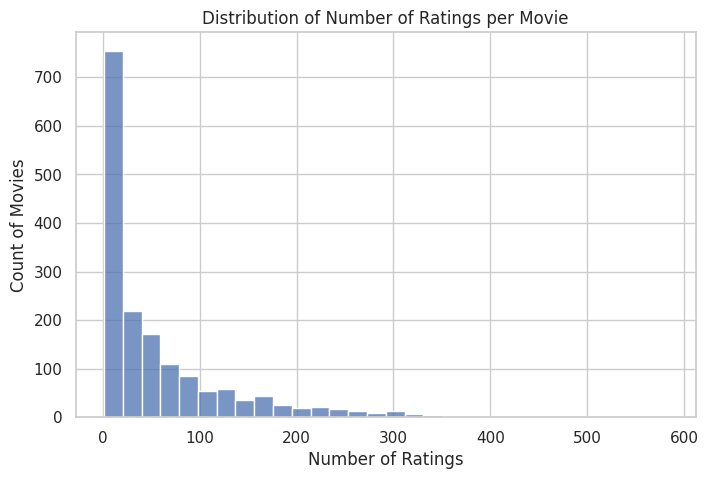

In [66]:
# Distribution of user ratings
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=5, kde=False)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Count of ratings per movie
ratings_per_movie = df.groupby('movieId')['rating'].count()
plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_movie, bins=30, kde=False)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()


## Feature Engineering

We now aggregate the ratings to compute movie-level statistics (average rating and count of ratings). Then, we create a binary target variable (`popular`)—a movie is considered popular if its average rating is 4 or higher.


In [67]:
# Aggregate ratings to compute movie-level statistics: mean rating and count of ratings per movie
movie_stats = df.groupby('movieId').agg(
    rating_mean=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Display a sample of the aggregated data
print("\nAggregated Movie Statistics:")
display(movie_stats.head(10))

# Check unique rating counts to see variability
print("Unique rating_count values:", movie_stats['rating_count'].unique())

# Inspect the distribution of the average ratings
print("\nRating Mean Distribution:")
print(movie_stats['rating_mean'].describe())



Aggregated Movie Statistics:


,movieId,rating_mean,rating_count
0,1,3.878319,452
1,2,3.206107,131
2,3,3.033333,90
3,4,3.550239,209
4,5,3.302326,86
5,6,3.576923,26
6,7,3.798469,392
7,8,3.995434,219
8,9,3.896321,299
9,10,3.831461,89


Unique rating_count values: [452 131  90 209  86  26 392 219 299  89 236 267 184 183 293  39  92  10
  69  72  84 297 182 174  73  57 276 114  37 154  81  97   7  11  13   8
 120  87 148  40  79  80  27 133 117 583  91 128 104 149 394 175  83  64
  59 127  82 283 115 162 103 134 321 251 220 129   5  54 151  33 336  68
 110 261 176  18  58 150 138 213 275  95 143 112 137 295 256 390 172 508
  15  74  71  42  65 130  31 272  20   9  67 125 378   4 429 106 187 244
 413  23 246 171 198 259 105  19  50  61 222 243 185 157 326 247  98  60
 101 316 118 121 367 324 420 208 284 221 507 226 291 116 239 170  66 124
 241 301 165 206 280 350 136 200 191 331 212 290 111 365  44 109 166 161
 199 142 217  45 384 156 132  48 240 160 197  46 158  62  16 303 509  43
 227  35 255 315 211 223 190 268 298  28  85 146 232 177 193 481  78 478
  96 147 485  77   6 194 431 230 188  30 145  75 102 168 169 218  41 113
  21  47 189  52  55 126  14 264  34  24 100 192  12  56  76 201 344  49
  70 163  93  25 178 30

In [68]:
# Merge the aggregated statistics with the movies DataFrame
movies_stats = pd.merge(movies, movie_stats, on='movieId')
print("\nMerged Movies and Aggregated Stats:")
display(movies_stats.head(10))

# Check the distribution of 'rating_mean' in the merged DataFrame
print("\nRating Mean Distribution in movies_stats:")
print(movies_stats['rating_mean'].describe())

# Create a binary target variable:
# For example, a movie is considered popular (1) if its average rating is >= 3.5, else 0.
movies_stats['popular'] = (movies_stats['rating_mean'] >= 3.5).astype(int)

# Check the target distribution to ensure both classes are present
print("\nTarget Distribution (popular):")
print(movies_stats['popular'].value_counts())


Merged Movies and Aggregated Stats:


,movieId,title,rating_mean,rating_count
0,1,Toy Story (1995),3.878319,452
1,2,GoldenEye (1995),3.206107,131
2,3,Four Rooms (1995),3.033333,90
3,4,Get Shorty (1995),3.550239,209
4,5,Copycat (1995),3.302326,86
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,3.576923,26
6,7,Twelve Monkeys (1995),3.798469,392
7,8,Babe (1995),3.995434,219
8,9,Dead Man Walking (1995),3.896321,299
9,10,Richard III (1995),3.831461,89



Rating Mean Distribution in movies_stats:
count    1682.000000
mean        3.076045
std         0.781662
min         1.000000
25%         2.659600
50%         3.161528
75%         3.653428
max         5.000000
Name: rating_mean, dtype: float64

Target Distribution (popular):
popular
0    1130
1     552
Name: count, dtype: int64


## Baseline Model: Logistic Regression

We will now use Logistic Regression to predict whether a movie is popular based on its average rating (`rating_mean`) and the count of ratings (`rating_count`).



Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       339
           1       1.00      0.99      1.00       166

    accuracy                           1.00       505
   macro avg       1.00      1.00      1.00       505
weighted avg       1.00      1.00      1.00       505



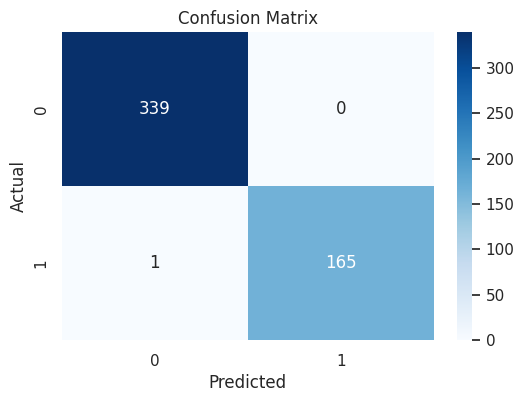

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define features (X) and target variable (y)
X = movies_stats[['rating_mean', 'rating_count']]
y = movies_stats['popular']

# Split the data into training and testing sets, stratifying to maintain the target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {accuracy:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## Conclusion and Next Steps

In this notebook, we:
- Loaded and merged the MovieLens data.
- Performed exploratory data analysis (EDA) to understand the distribution of ratings.
- Engineered features by aggregating movie-level statistics.
- Built a baseline Logistic Regression model to predict movie popularity.

### Key Findings:
- The distribution of user ratings and the number of ratings per movie provide insights into movie engagement.
- The baseline model offers a starting point for predicting movie popularity.

### Next Steps:
- Enhance feature engineering by incorporating additional attributes (e.g., genres).
- Experiment with more advanced classification models such as Random Forest or XGBoost.
- Refine visualizations to better communicate insights to both technical and non-technical stakeholders.
